In [2]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF

In [3]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root="..", download=True, train=True)
test_dataset = datasets.MNIST(root="..", download=True, train=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw




Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Dataset interface: len
print(f"Num. training samples: {len(train_dataset)}")
print(f"Num. test samples:     {len(test_dataset)}")

Num. training samples: 60000
Num. test samples:     10000


In [5]:
# Dataset interface: []
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F0B059909D0>, 5)

In [6]:
train_dataset[10][0]

In [7]:
train_dataset[10][1]

3

In [8]:
# Convert image to tensor
t = TF.to_tensor(train_dataset[0][0])

In [9]:
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [10]:
t.size()

torch.Size([1, 28, 28])

In [11]:
t.type()

'torch.FloatTensor'

## Homework: train a classifier on MNIST

- Organize the dataset into an easily indexable way (e.g. matrices, as in the examples)
  - **Hint:** `X_train` and `X_test` can actually be vectors of indexes to `train_dataset` and `test_dataset`
- (Optional) Split the training set into training and validation
- Standardize the dataset
  - Don't use PyTorch "normalization" tools
- Train your model
  - MNIST images are matrices: vectorize them with `view()`
  - (Optional) Implement mini-batch SGD: just pass a `(B,F)` tensor to the classifier (`B`: mini-batch size; `F`: feature length)
    - In this case, you will have to change some of the code for computing accuracy
- Monitor training and test loss (and validation, if implemented)
- Plot training/test (and validation, if implemented) loss/accuracy
- Try different classifier architectures
- Evaluate the model's performance:
  - If you use the validation set, your final model will be the one that achieves the highest validation accuracy
  - If you don't use a validation set, your final model will be the one that achieves the highest training accuracy

#Homework2 Solution by Salvatore Cavallaro (Student ID: 1000008690)

In [12]:
# Models
import torch.nn as nn # layers with parameters
import torch.nn.functional as F # layers without parameters (e.g. activation functions)
import torch.optim as optim

Let's define a function to create 4 tensors from MNIST dataset (Test and Train datasets and Test and Train labels) where each row of $28x28$ elements is an image

In [12]:
def tensorFromImage(train_dataset, test_dataset, rows, columns): #28x28
  #a 4D tensor is created from MNIST dataset
  size_training = len(train_dataset)
  size_test = len(test_dataset)

  X_train = torch.zeros(size_training, 1, rows, columns)
  Y_train = torch.zeros(size_training, 1, dtype=torch.int32)

  X_test = torch.zeros(size_test, 1, rows, columns)
  Y_test = torch.zeros(size_test, 1, dtype=torch.int32)

  for sample in range(size_training):
    X_train[sample] = TF.to_tensor(train_dataset[sample][0])
    Y_train[sample] = train_dataset[sample][1]

  for sample in range(size_test):
    X_test[sample] = TF.to_tensor(test_dataset[sample][0])
    Y_test[sample] = test_dataset[sample][1]

  #each image becomes a vector row
  X_train = X_train.view(size_training, 28 * 28)
  X_test = X_test.view(size_test, 28 * 28)

  #shuffling operation is performed
  shuffle_train = torch.randperm(size_training)
  shuffle_test = torch.randperm(size_test)

  X_train = X_train[shuffle_train, :]
  Y_train = Y_train[shuffle_train, :]
  X_test = X_test[shuffle_test, :]
  Y_test = Y_test[shuffle_test, :]
  
  return X_train, Y_train, X_test, Y_test

Now it is time to do a standardization of the datasets:

In [13]:
def standardization(X_train, X_test):
  #std vector computation
  X_train_std = torch.std(X_train, dim=0)
  X_test_std = torch.std(X_test, dim=0)
  X_train_std = X_train_std.unsqueeze(0)
  X_test_std = X_test_std.unsqueeze(0)

  #mean vector computation
  X_train_mean = torch.mean(X_train,0)
  X_test_mean = torch.mean(X_test, dim=0)
  X_train_mean = X_train_mean.unsqueeze(0)
  X_test_mean = X_test_mean.unsqueeze(0)

  #standardization computation
  X_train = (X_train - X_train_mean) / X_train_std
  X_test = (X_test - X_test_mean) / X_test_std

  #conversion of NaN values to 0
  X_train = torch.nan_to_num(X_train)
  X_test = torch.nan_to_num(X_test)

  return X_train, X_test

Another function we define is the one used for training the neural network using the provided dataset of images:

In [14]:
def train(model, X_train, y_train, X_test, y_test, epochs, lr=0.01):
    #here we define used optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    #get the number of samples in training and test sets
    num_train = X_train.size(0)
    num_test = X_test.size(0)

    #here we define some lists which will hold information about loss and accuracy of test and training sets
    history_train_loss = []
    history_train_accuracy = []
    history_test_loss = []
    history_test_accuracy = []
    
    #main loop defining operation executed foreach epoch
    for epoch in range(epochs):
        #initialize epoch variables
        sum_train_loss = 0
        sum_test_loss = 0
        sum_train_accuracy = 0
        sum_test_accuracy = 0
        
        #enable gradient computation
        torch.set_grad_enabled(True)
        #training loop
        for i in range(num_train):
            #reset gradients
            optimizer.zero_grad()
            #get sample i (stochastic approach)
            features = X_train[i,:]
            label = y_train[i]
            #add batch dimension for features
            features.unsqueeze_(0)
            #compute prediction
            pred = model(features)
            loss = F.cross_entropy(pred, label.type(torch.LongTensor))
            #update train loss
            sum_train_loss += loss.item()
            #compute gradients
            loss.backward()
            #optimize
            optimizer.step()
            #update train accuracy
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_train_accuracy += 1
        
        #disable gradient computation
        torch.set_grad_enabled(False)
        #test loop
        for i in range(num_test):
            features = X_test[i,:]
            label = y_test[i]
            features.unsqueeze_(0)
            pred = model(features)
            loss = F.cross_entropy(pred, label.type(torch.LongTensor))
            sum_test_loss += loss.item()
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_test_accuracy += 1
        
        #loss & accuracy information update for this epoch
        epoch_train_loss = sum_train_loss/num_train
        epoch_train_accuracy = sum_train_accuracy/num_train
        epoch_test_loss = sum_test_loss/num_test
        epoch_test_accuracy = sum_test_accuracy/num_test
        history_train_loss.append(epoch_train_loss)
        history_train_accuracy.append(epoch_train_accuracy)
        history_test_loss.append(epoch_test_loss)
        history_test_accuracy.append(epoch_test_accuracy)
        
        print(f"Epoch {epoch}:",
              f"TrL={epoch_train_loss:.4f},",
              f"TrA={epoch_train_accuracy:.4f},",
              f"TeL={epoch_test_loss:.4f},",
              f"TeA={epoch_test_accuracy:.4f}")
    
    # Plot loss
    plt.title("Loss")
    plt.plot(history_train_loss, label='train')
    plt.plot(history_test_loss, label='test')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.title("Accuracy")
    plt.plot(history_train_accuracy, label='train')
    plt.plot(history_test_accuracy, label='test')
    plt.legend()
    plt.show()
    

###Dataset preprocessing

We execute data preprocessing of our MNIST dataset using the above defined functions

In [29]:
X_train, Y_train, X_test, Y_test = tensorFromImage(train_dataset, test_dataset, 28, 28)

In [30]:
X_train, X_test = standardization(X_train, X_test)

###First attempt

Here we define the first architecture for the Neural Network we are going to use:

In [18]:
class NNModel(nn.Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        # Call parent constructor
        super().__init__()
        # Define layers
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    # Forward (prediction)
    def forward(self, x):
        # Go through network
        x = torch.tanh(self.hidden_layer(x))
        x = self.output_layer(x)
        # Return output
        return x

Next, we can define hyperparameters for the actual Neural Network:

In [19]:
input_size = X_train.size(1)
hidden_size = 10
output_size = Y_train.max().item() + 1
lr = 0.1
epochs = 100

model = NNModel(input_size, hidden_size, output_size)

Here we try to train the model using a first combination of hyperparameters:

Epoch 0: TrL=0.7310, TrA=0.7759, TeL=0.6266, TeA=0.8265
Epoch 1: TrL=0.5861, TrA=0.8275, TeL=0.5550, TeA=0.8449
Epoch 2: TrL=0.5532, TrA=0.8364, TeL=0.5431, TeA=0.8457
Epoch 3: TrL=0.5307, TrA=0.8448, TeL=0.5297, TeA=0.8523
Epoch 4: TrL=0.5201, TrA=0.8481, TeL=0.5135, TeA=0.8577
Epoch 5: TrL=0.4992, TrA=0.8550, TeL=0.5215, TeA=0.8510
Epoch 6: TrL=0.4836, TrA=0.8617, TeL=0.5131, TeA=0.8599
Epoch 7: TrL=0.4819, TrA=0.8605, TeL=0.5091, TeA=0.8547
Epoch 8: TrL=0.4794, TrA=0.8631, TeL=0.4924, TeA=0.8594
Epoch 9: TrL=0.4685, TrA=0.8655, TeL=0.4886, TeA=0.8598
Epoch 10: TrL=0.4694, TrA=0.8647, TeL=0.4640, TeA=0.8628
Epoch 11: TrL=0.4580, TrA=0.8695, TeL=0.4760, TeA=0.8741
Epoch 12: TrL=0.4538, TrA=0.8707, TeL=0.4841, TeA=0.8707
Epoch 13: TrL=0.4537, TrA=0.8708, TeL=0.4561, TeA=0.8756
Epoch 14: TrL=0.4486, TrA=0.8740, TeL=0.4783, TeA=0.8710
Epoch 15: TrL=0.4494, TrA=0.8728, TeL=0.4731, TeA=0.8724
Epoch 16: TrL=0.4374, TrA=0.8768, TeL=0.4601, TeA=0.8759
Epoch 17: TrL=0.4330, TrA=0.8779, TeL=0.4

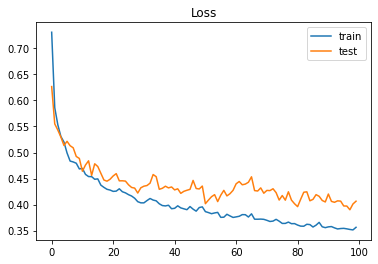

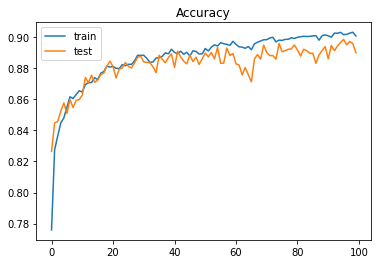

In [42]:
train(model, X_train, Y_train, X_test, Y_test, epochs, lr)

###Second attempt

Using the same architecture of the first attempt we try to change some hyperparameters:

Epoch 0: TrL=0.6769, TrA=0.8078, TeL=0.5329, TeA=0.8529
Epoch 1: TrL=0.5642, TrA=0.8445, TeL=0.5331, TeA=0.8609
Epoch 2: TrL=0.5221, TrA=0.8579, TeL=0.4852, TeA=0.8762
Epoch 3: TrL=0.4870, TrA=0.8679, TeL=0.4673, TeA=0.8782
Epoch 4: TrL=0.4666, TrA=0.8755, TeL=0.5001, TeA=0.8694
Epoch 5: TrL=0.4624, TrA=0.8755, TeL=0.4445, TeA=0.8814
Epoch 6: TrL=0.4453, TrA=0.8806, TeL=0.4269, TeA=0.8930
Epoch 7: TrL=0.4285, TrA=0.8859, TeL=0.4222, TeA=0.8902
Epoch 8: TrL=0.4265, TrA=0.8844, TeL=0.4175, TeA=0.8941
Epoch 9: TrL=0.4144, TrA=0.8875, TeL=0.4356, TeA=0.8883
Epoch 10: TrL=0.3985, TrA=0.8933, TeL=0.4062, TeA=0.8952
Epoch 11: TrL=0.3931, TrA=0.8941, TeL=0.4054, TeA=0.9018
Epoch 12: TrL=0.3857, TrA=0.8963, TeL=0.3869, TeA=0.9066
Epoch 13: TrL=0.3806, TrA=0.8989, TeL=0.3841, TeA=0.9057
Epoch 14: TrL=0.3760, TrA=0.8989, TeL=0.3877, TeA=0.9032
Epoch 15: TrL=0.3751, TrA=0.9005, TeL=0.3795, TeA=0.9053
Epoch 16: TrL=0.3689, TrA=0.9016, TeL=0.3933, TeA=0.8969
Epoch 17: TrL=0.3626, TrA=0.9032, TeL=0.4

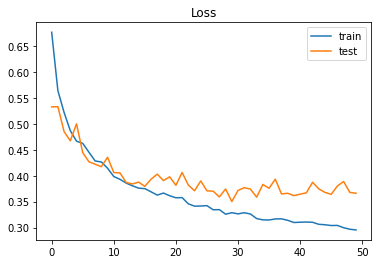

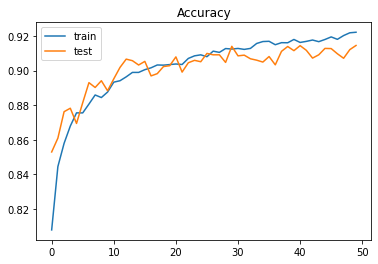

In [72]:
hidden_size = 25
lr = 0.1
epochs = 50

model = NNModel(input_size, hidden_size, output_size)

train(model, X_train, Y_train, X_test, Y_test, epochs, lr)

###Third attempt

We try to use a different architecture:

In [92]:
class NNModel2(nn.Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        # Call parent constructor
        super().__init__()
        # Define layers
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    # Forward (prediction)
    def forward(self, x):
        # Go through network
        x = torch.tanh(self.hidden_layer1(x))
        x = torch.tanh(self.hidden_layer2(x))
        x = torch.tanh(self.hidden_layer3(x))
        x = self.output_layer(x)
        # Return output
        return x

Epoch 0: TrL=0.3538, TrA=0.8945, TeL=0.2672, TeA=0.9239
Epoch 1: TrL=0.2496, TrA=0.9260, TeL=0.2495, TeA=0.9287
Epoch 2: TrL=0.2222, TrA=0.9342, TeL=0.2324, TeA=0.9335
Epoch 3: TrL=0.2021, TrA=0.9402, TeL=0.2382, TeA=0.9326
Epoch 4: TrL=0.1967, TrA=0.9409, TeL=0.2286, TeA=0.9365
Epoch 5: TrL=0.1868, TrA=0.9447, TeL=0.2302, TeA=0.9349
Epoch 6: TrL=0.1794, TrA=0.9463, TeL=0.2205, TeA=0.9398
Epoch 7: TrL=0.1726, TrA=0.9487, TeL=0.2255, TeA=0.9377
Epoch 8: TrL=0.1654, TrA=0.9508, TeL=0.2263, TeA=0.9361
Epoch 9: TrL=0.1655, TrA=0.9501, TeL=0.2153, TeA=0.9377
Epoch 10: TrL=0.1621, TrA=0.9510, TeL=0.2161, TeA=0.9382
Epoch 11: TrL=0.1550, TrA=0.9535, TeL=0.2088, TeA=0.9422
Epoch 12: TrL=0.1550, TrA=0.9527, TeL=0.2143, TeA=0.9382
Epoch 13: TrL=0.1496, TrA=0.9541, TeL=0.2173, TeA=0.9369
Epoch 14: TrL=0.1509, TrA=0.9547, TeL=0.2117, TeA=0.9425
Epoch 15: TrL=0.1438, TrA=0.9575, TeL=0.2241, TeA=0.9381
Epoch 16: TrL=0.1456, TrA=0.9562, TeL=0.2129, TeA=0.9399
Epoch 17: TrL=0.1471, TrA=0.9564, TeL=0.2

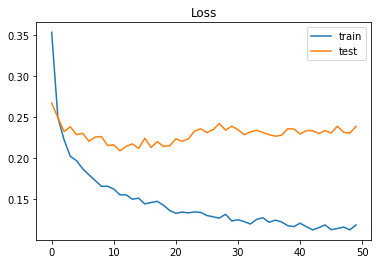

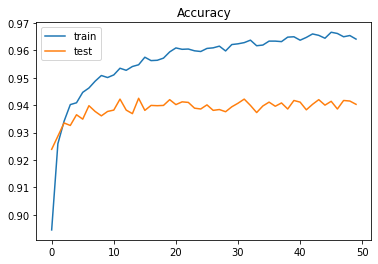

In [78]:
hidden_size = 25
lr = 0.01
epochs = 50

model2 = NNModel2(input_size, hidden_size, output_size)

train(model2, X_train, Y_train, X_test, Y_test, epochs, lr)

###Fourth attempt

Another different architecture:

In [87]:
class NNModel3(nn.Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        # Call parent constructor
        super().__init__()
        # Define layers
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    # Forward (prediction)
    def forward(self, x):
        # Go through network
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = self.output_layer(x)
        # Return output
        return x

Epoch 0: TrL=0.5691, TrA=0.8098, TeL=0.2647, TeA=0.9223
Epoch 1: TrL=0.2508, TrA=0.9247, TeL=0.2162, TeA=0.9340
Epoch 2: TrL=0.2129, TrA=0.9358, TeL=0.2101, TeA=0.9368
Epoch 3: TrL=0.1887, TrA=0.9421, TeL=0.1964, TeA=0.9426
Epoch 4: TrL=0.1741, TrA=0.9471, TeL=0.2082, TeA=0.9371
Epoch 5: TrL=0.1621, TrA=0.9516, TeL=0.1865, TeA=0.9468
Epoch 6: TrL=0.1535, TrA=0.9541, TeL=0.1944, TeA=0.9450
Epoch 7: TrL=0.1442, TrA=0.9569, TeL=0.1955, TeA=0.9437
Epoch 8: TrL=0.1383, TrA=0.9583, TeL=0.1942, TeA=0.9457
Epoch 9: TrL=0.1335, TrA=0.9591, TeL=0.1931, TeA=0.9462
Epoch 10: TrL=0.1327, TrA=0.9588, TeL=0.2069, TeA=0.9429
Epoch 11: TrL=0.1265, TrA=0.9607, TeL=0.1894, TeA=0.9467
Epoch 12: TrL=0.1234, TrA=0.9618, TeL=0.1995, TeA=0.9455
Epoch 13: TrL=0.1178, TrA=0.9638, TeL=0.1817, TeA=0.9485
Epoch 14: TrL=0.1180, TrA=0.9633, TeL=0.1876, TeA=0.9492
Epoch 15: TrL=0.1175, TrA=0.9635, TeL=0.1832, TeA=0.9514
Epoch 16: TrL=0.1147, TrA=0.9634, TeL=0.1911, TeA=0.9477
Epoch 17: TrL=0.1083, TrA=0.9660, TeL=0.1

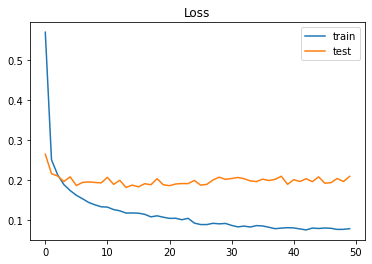

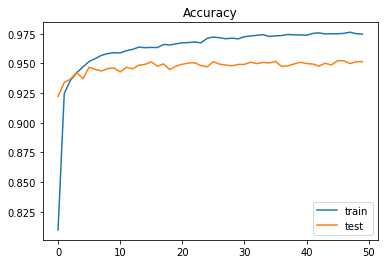

In [22]:
hidden_size = 50
lr = 0.1
epochs = 50

model3 = NNModel3(input_size, hidden_size, output_size)

train(model3, X_train, Y_train, X_test, Y_test, epochs, lr)

###Final Considerations

A deep evaluation of metrics provided by each one of the models above shows that the best solution is the one defined in "Fourth attempt".

###Optional part

In this section we are going to implement a different splitting of the dataset: TRAINING, VALIDATION and TEST.

In [13]:
def tensorFromImageCross(train_dataset, test_dataset, rows, columns): #28x28
  #a 4D tensor is created from MNIST dataset
  size_training = len(train_dataset) - len(test_dataset)
  size_validation = len(test_dataset)
  size_test = len(test_dataset)

  X_train = torch.zeros(size_training, 1, rows, columns)
  Y_train = torch.zeros(size_training, 1, dtype=torch.int32)

  X_validation = torch.zeros(size_validation, 1, rows, columns)
  Y_validation = torch.zeros(size_validation, 1, dtype=torch.int32)

  X_test = torch.zeros(size_test, 1, rows, columns)
  Y_test = torch.zeros(size_test, 1, dtype=torch.int32)

  for sample in range(size_training):
    X_train[sample] = TF.to_tensor(train_dataset[sample][0])
    Y_train[sample] = train_dataset[sample][1]

  for sample in range(size_validation):
    X_validation[sample] = TF.to_tensor(train_dataset[sample + size_training][0])
    Y_validation[sample] = train_dataset[sample + size_training][1]

  for sample in range(size_test):
    X_test[sample] = TF.to_tensor(test_dataset[sample][0])
    Y_test[sample] = test_dataset[sample][1]

  #each image becomes a vector row
  X_train = X_train.view(size_training, 28 * 28)
  X_validation = X_validation.view(size_validation, 28 * 28)
  X_test = X_test.view(size_test, 28 * 28)

  #shuffling operation is performed
  shuffle_train = torch.randperm(size_training)
  shuffle_validation = torch.randperm(size_validation)
  shuffle_test = torch.randperm(size_test)

  X_train = X_train[shuffle_train, :]
  Y_train = Y_train[shuffle_train, :]
  X_validation = X_validation[shuffle_validation, :]
  Y_validation = Y_validation[shuffle_validation, :]
  X_test = X_test[shuffle_test, :]
  Y_test = Y_test[shuffle_test, :]
  
  return X_train, Y_train, X_validation, Y_validation, X_test, Y_test

In [14]:
def standardizationCross(X_train, X_validation, X_test):
  #std vector computation
  X_train_std = torch.std(X_train, dim=0)
  X_validation_std = torch.std(X_validation, dim=0)
  X_test_std = torch.std(X_test, dim=0)
  X_train_std = X_train_std.unsqueeze(0)
  X_validation_std = X_validation_std.unsqueeze(0)
  X_test_std = X_test_std.unsqueeze(0)

  #mean vector computation
  X_train_mean = torch.mean(X_train,0)
  X_validation_mean = torch.mean(X_validation, 0)
  X_test_mean = torch.mean(X_test, dim=0)
  X_train_mean = X_train_mean.unsqueeze(0)
  X_validation_mean = X_validation_mean.unsqueeze(0)
  X_test_mean = X_test_mean.unsqueeze(0)

  #standardization computation
  X_train = (X_train - X_train_mean) / X_train_std
  X_validation = (X_validation - X_validation_mean) / X_validation_std
  X_test = (X_test - X_test_mean) / X_test_std

  #conversion of NaN values to 0
  X_train = torch.nan_to_num(X_train)
  X_validation = torch.nan_to_num(X_validation)
  X_test = torch.nan_to_num(X_test)

  return X_train, X_validation, X_test

In [15]:
def fit(model, X_train, y_train, X_validation, y_validation, X_test, y_test, epochs, lr=0.01):
    #here we define used optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    #get the number of samples in training and test sets
    num_train = X_train.size(0)
    num_validation = X_validation.size(0)
    num_test = X_test.size(0)

    #here we define some lists which will hold information about loss and accuracy of test and training sets
    history_train_loss = []
    history_train_accuracy = []
    history_validation_loss = []
    history_validation_accuracy = []
    history_test_loss = []
    history_test_accuracy = []
    
    #main loop defining operation executed foreach epoch
    for epoch in range(epochs):
        #initialize epoch variables
        sum_train_loss = 0
        sum_validation_loss = 0
        sum_test_loss = 0    
        sum_train_accuracy = 0
        sum_validation_accuracy = 0
        sum_test_accuracy = 0
        
        #enable gradient computation
        torch.set_grad_enabled(True)
        #training loop
        for i in range(num_train):
            optimizer.zero_grad()
            features = X_train[i,:]
            label = y_train[i]
            features.unsqueeze_(0)
            pred = model(features)
            loss = F.cross_entropy(pred, label.type(torch.LongTensor))
            sum_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_train_accuracy += 1
        
        #disable gradient computation
        torch.set_grad_enabled(False)
        #validation_loop
        for i in range(num_validation):
            features = X_validation[i,:]
            label = y_validation[i]
            features.unsqueeze_(0)
            pred = model(features)
            loss = F.cross_entropy(pred, label.type(torch.LongTensor))
            sum_validation_loss += loss.item()
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_validation_accuracy += 1  

        #test loop
        for i in range(num_test):
            features = X_test[i,:]
            label = y_test[i]
            features.unsqueeze_(0)
            pred = model(features)
            loss = F.cross_entropy(pred, label.type(torch.LongTensor))
            sum_test_loss += loss.item()
            _,pred_label = pred.max(1)
            pred_label = pred_label.item()
            if pred_label == label.item():
                sum_test_accuracy += 1
        
        #loss & accuracy information update for this epoch
        epoch_train_loss = sum_train_loss/num_train
        epoch_train_accuracy = sum_train_accuracy/num_train
        epoch_validation_loss = sum_validation_loss/num_validation
        epoch_validation_accuracy = sum_validation_accuracy/num_validation
        epoch_test_loss = sum_test_loss/num_test
        epoch_test_accuracy = sum_test_accuracy/num_test
        history_train_loss.append(epoch_train_loss)
        history_train_accuracy.append(epoch_train_accuracy)
        history_validation_loss.append(epoch_validation_loss)
        history_validation_accuracy.append(epoch_validation_accuracy)
        history_test_loss.append(epoch_test_loss)
        history_test_accuracy.append(epoch_test_accuracy)
        
        print(f"Epoch {epoch}:",
              f"TrL={epoch_train_loss:.4f},",
              f"TrA={epoch_train_accuracy:.4f},",
              f"VaL={epoch_validation_loss:.4f},",
              f"VaA={epoch_validation_accuracy:.4f},",
              f"TeL={epoch_test_loss:.4f},",
              f"TeA={epoch_test_accuracy:.4f}")
    
    # Plot loss
    plt.title("Loss")
    plt.plot(history_train_loss, label='train')
    plt.plot(history_validation_loss, label='validation')
    plt.plot(history_test_loss, label='test')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.title("Accuracy")
    plt.plot(history_train_accuracy, label='train')
    plt.plot(history_validation_accuracy, label='validation')
    plt.plot(history_test_accuracy, label='test')
    plt.legend()
    plt.show()
    
    

Let's train our model

In [16]:
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = tensorFromImageCross(train_dataset, test_dataset, 28, 28)

In [17]:
X_train, X_validation, X_test = standardizationCross(X_train, X_validation, X_test)

In [20]:
class NNModel4(nn.Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        # Call parent constructor
        super().__init__()
        # Define layers
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    # Forward (prediction)
    def forward(self, x):
        # Go through network
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = self.output_layer(x)
        # Return output
        return x

We use the NN architecture defined above:

Epoch 0: TrL=1.2620, TrA=0.5483, VaL=0.3990, VaA=0.8932, TeL=0.4274, TeA=0.8844
Epoch 1: TrL=0.3149, TrA=0.9083, VaL=0.2482, VaA=0.9318, TeL=0.2672, TeA=0.9265
Epoch 2: TrL=0.2035, TrA=0.9413, VaL=0.1995, VaA=0.9429, TeL=0.2180, TeA=0.9376
Epoch 3: TrL=0.1544, TrA=0.9555, VaL=0.1940, VaA=0.9451, TeL=0.2050, TeA=0.9411
Epoch 4: TrL=0.1238, TrA=0.9637, VaL=0.1893, VaA=0.9480, TeL=0.2023, TeA=0.9448
Epoch 5: TrL=0.1046, TrA=0.9698, VaL=0.1900, VaA=0.9482, TeL=0.1983, TeA=0.9468
Epoch 6: TrL=0.0867, TrA=0.9755, VaL=0.1964, VaA=0.9483, TeL=0.2121, TeA=0.9438
Epoch 7: TrL=0.0736, TrA=0.9800, VaL=0.2006, VaA=0.9487, TeL=0.2139, TeA=0.9424
Epoch 8: TrL=0.0633, TrA=0.9833, VaL=0.2073, VaA=0.9494, TeL=0.2147, TeA=0.9474
Epoch 9: TrL=0.0548, TrA=0.9857, VaL=0.2089, VaA=0.9497, TeL=0.2195, TeA=0.9470
Epoch 10: TrL=0.0499, TrA=0.9864, VaL=0.2172, VaA=0.9485, TeL=0.2226, TeA=0.9479
Epoch 11: TrL=0.0439, TrA=0.9883, VaL=0.2245, VaA=0.9474, TeL=0.2308, TeA=0.9463
Epoch 12: TrL=0.0396, TrA=0.9900, VaL=

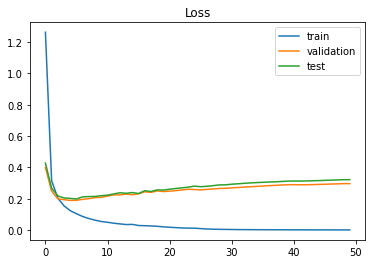

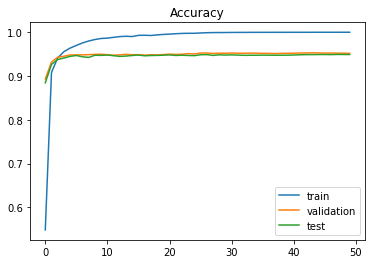

In [170]:
hidden_size = 50
lr = 0.01
epochs = 50

model4 = NNModel4(input_size, hidden_size, output_size)

fit(model4, X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, lr)

In [21]:
class NNModel5(nn.Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        # Call parent constructor
        super().__init__()
        # Define layers
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer4 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    # Forward (prediction)
    def forward(self, x):
        # Go through network
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = torch.relu(self.hidden_layer3(x))
        x = torch.relu(self.hidden_layer4(x))
        x = self.output_layer(x)
        # Return output
        return x

Epoch 0: TrL=0.9765, TrA=0.6769, VaL=0.2402, VaA=0.9368, TeL=0.2545, TeA=0.9297
Epoch 1: TrL=0.1931, TrA=0.9440, VaL=0.1532, VaA=0.9574, TeL=0.1754, TeA=0.9533
Epoch 2: TrL=0.1266, TrA=0.9627, VaL=0.1367, VaA=0.9617, TeL=0.1596, TeA=0.9576
Epoch 3: TrL=0.0919, TrA=0.9728, VaL=0.1358, VaA=0.9639, TeL=0.1565, TeA=0.9618
Epoch 4: TrL=0.0698, TrA=0.9807, VaL=0.1273, VaA=0.9680, TeL=0.1497, TeA=0.9650
Epoch 5: TrL=0.0538, TrA=0.9848, VaL=0.1377, VaA=0.9673, TeL=0.1572, TeA=0.9649
Epoch 6: TrL=0.0416, TrA=0.9887, VaL=0.1380, VaA=0.9695, TeL=0.1597, TeA=0.9667
Epoch 7: TrL=0.0353, TrA=0.9902, VaL=0.1484, VaA=0.9667, TeL=0.1666, TeA=0.9678
Epoch 8: TrL=0.0320, TrA=0.9912, VaL=0.1648, VaA=0.9657, TeL=0.1946, TeA=0.9631
Epoch 9: TrL=0.0297, TrA=0.9921, VaL=0.1555, VaA=0.9666, TeL=0.1815, TeA=0.9655
Epoch 10: TrL=0.0221, TrA=0.9939, VaL=0.1573, VaA=0.9691, TeL=0.1812, TeA=0.9690
Epoch 11: TrL=0.0194, TrA=0.9951, VaL=0.1649, VaA=0.9680, TeL=0.1862, TeA=0.9670
Epoch 12: TrL=0.0184, TrA=0.9947, VaL=

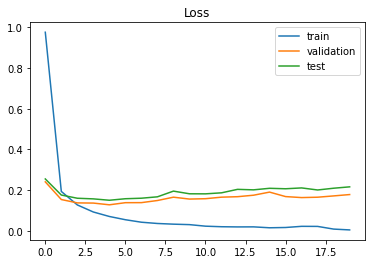

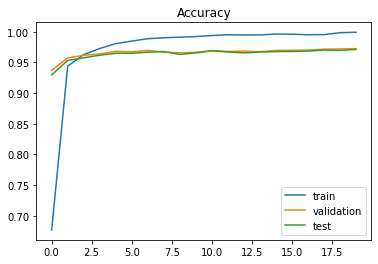

In [174]:
hidden_size = 80
lr = 0.001
epochs = 20

model5 = NNModel5(input_size, hidden_size, output_size)

fit(model5, X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, lr)

Another solution is the following:

Epoch 0: TrL=0.8677, TrA=0.7199, VaL=0.2118, VaA=0.9399, TeL=0.2313, TeA=0.9354
Epoch 1: TrL=0.1796, TrA=0.9478, VaL=0.1565, VaA=0.9582, TeL=0.1636, TeA=0.9548
Epoch 2: TrL=0.1142, TrA=0.9666, VaL=0.1359, VaA=0.9638, TeL=0.1379, TeA=0.9621
Epoch 3: TrL=0.0805, TrA=0.9758, VaL=0.1291, VaA=0.9678, TeL=0.1320, TeA=0.9635
Epoch 4: TrL=0.0596, TrA=0.9829, VaL=0.1268, VaA=0.9676, TeL=0.1273, TeA=0.9650
Epoch 5: TrL=0.0442, TrA=0.9874, VaL=0.1339, VaA=0.9695, TeL=0.1330, TeA=0.9653
Epoch 6: TrL=0.0379, TrA=0.9906, VaL=0.1325, VaA=0.9690, TeL=0.1289, TeA=0.9669
Epoch 7: TrL=0.0271, TrA=0.9935, VaL=0.1347, VaA=0.9711, TeL=0.1291, TeA=0.9701
Epoch 8: TrL=0.0227, TrA=0.9943, VaL=0.1477, VaA=0.9711, TeL=0.1428, TeA=0.9712
Epoch 9: TrL=0.0270, TrA=0.9934, VaL=0.1529, VaA=0.9696, TeL=0.1618, TeA=0.9666


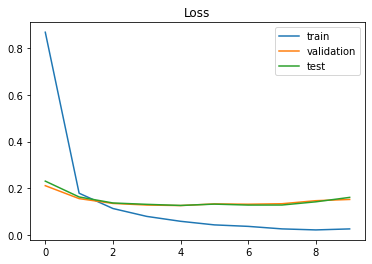

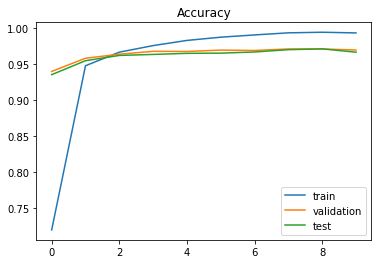

In [26]:
hidden_size = 100
lr = 0.001
epochs = 10

model5 = NNModel5(input_size, hidden_size, output_size)

fit(model5, X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, lr)

Last model has got a validation accuracy value approximately equal to the one of its preceding model but using a lower number of epochs. Therefore this is the final choice.